In [1]:
from IPython.display import Markdown as md
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from CifFile import ReadCif
from os import path
import numpy as np
import subprocess

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

<a id='table_of_contents'></a>
# Table of Contents
1. [Loading crystal data and finding the center of the pore](#Loading_crystal_data_and_finding_the_center_of_the_pore)
2. [Centering the unit cell](#centering_the_unit_cell)
3. [The manybody potential](#the_manybody_potential)
4. [Calculating the manybody potential](#calculating_the_manybody_potential)
5. [Determining the effective parameters to cylindrical potential](#determining_the_effective_parameters_to_cylindrical_potential)
6. [Effective parameters using potential cutoff](#effective_parameters_using_potential_cutoff)
7. [Effective parameters using radial cutoff](#effective_parameters_using_radial_cutoff)

<a id='Loading_crystal_data_and_finding_the_center_of_the_pore'></a>
### Loading crystal data and finding the center of the pore
[Table of Contents](#table_of_contents)

We will begin by loading the CIF file ([from here](https://doi.org/10.1002/adma.200801489)) and extracting some of the contents.

In [2]:
mcm41_cif_file = '../Data/mcm-41.cif'

We print the contents of the cif file to check the structure and find useful information.

In [3]:
def print_cif(filename):
    """prints information contained within cif file"""
    cif_data = ReadCif(filename)
    print(cif_data)

In [4]:
print_cif(mcm41_cif_file)

Writing CSD_CIF_MOLDRAW, <CifFile.StarFile.StarBlock object at 0x7f371a91b908>
All blocks output.

##########################################################################
#               Crystallographic Information Format file
#               Produced by PyCifRW module
#
#  This is a CIF file.  CIF has been adopted by the International
#  Union of Crystallography as the standard for data archiving and
#  transmission.
#
#  For information on this file format, follow the CIF links at
#  http://www.iucr.org
##########################################################################

data_CSD_CIF_MOLDRAW

_audit_creation_date                    08-23-2013
_audit_creation_method                  MOLDRAW
_chemical_formula_sum                   'H102 O335 Si142'
_chemical_formula_moiety                
;
H102 O335 Si142
;
loop_
  _publ_author_name
         Piero     
         Ugliengo  
         Dip.      
         Chimica   
         University          
         of        
         Tori

The cif format is cumbersome for our uses so we convert to [xyz format](https://en.wikipedia.org/wiki/XYZ_file_format) using [Open Babel](https://open-babel.readthedocs.io/en/latest/index.html).

In [5]:
def convert_cif_to_xyz(cif_filename,xyz_filename=None,obabel="obabel"):
    """converts cif file to xyz file using babel as a subprocess"""
    if xyz_filename is None:
        xyz_filename = path.splitext(cif_filename)[0] + ".xyz"
        
    babel_process = subprocess.run([obabel, "-icif", cif_filename, "-oxyz", "-O{}".format(xyz_filename)], stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    
    try:
        print(babel_process.stdout.decode("utf-8"))
    except:
        pass
    try:
        print(babel_process.stderr.decode("utf-8"))
    except:
        pass
    if ("molecule converted" in babel_process.stdout.decode("utf-8")) or ("molecule converted" in babel_process.stderr.decode("utf-8")):
        print("XYZ file saved to {}".format(xyz_filename))
    else:
        raise OSError("{} not converted.".format(cif_filename))

In [6]:
convert_cif_to_xyz(mcm41_cif_file)


1 molecule converted

XYZ file saved to ../Data/mcm-41.xyz


Now we can load the xyz file (which is now in cartesian coordinates).

In [7]:
mcm41_xyz_file = "../Data/mcm-41.xyz"
mcm41_basename = path.basename(path.splitext(mcm41_xyz_file)[0]) #We'll use this when naming files later

Useful parameters can be extracted from the cif file and atom positions from the xyz file.

In [8]:
mcm41_cif = ReadCif(mcm41_cif_file)
mcm41_xyz = np.genfromtxt(mcm41_xyz_file,skip_header=2,dtype=[('type_symbol','|S2'),('x','f'),('y','f'),('z','f')])

In [9]:
label =       np.array(mcm41_cif['csd_cif_moldraw']['_atom_site_label'])
type_symbol = np.array(mcm41_cif['csd_cif_moldraw']['_atom_site_type_symbol'])
fract_x =     np.array(mcm41_cif['csd_cif_moldraw']['_atom_site_fract_x'],dtype=float)
fract_y =     np.array(mcm41_cif['csd_cif_moldraw']['_atom_site_fract_y'],dtype=float)
fract_z =     np.array(mcm41_cif['csd_cif_moldraw']['_atom_site_fract_z'],dtype=float)
cell_length_a = float(mcm41_cif['csd_cif_moldraw']['_cell_length_a'])
cell_length_b = float(mcm41_cif['csd_cif_moldraw']['_cell_length_b'])
cell_length_c = float(mcm41_cif['csd_cif_moldraw']['_cell_length_c'])
cell_angle_alpha = float(mcm41_cif['csd_cif_moldraw']['_cell_angle_alpha'])*np.pi/180.0
cell_angle_beta = float(mcm41_cif['csd_cif_moldraw']['_cell_angle_beta'])*np.pi/180.0
cell_angle_gamma = float(mcm41_cif['csd_cif_moldraw']['_cell_angle_gamma'])*np.pi/180.0

Lattice vectors can be generated from the extracted parameters.

In [10]:
ax1 = cell_length_a
ay1 = 0.0
ax2 = cell_length_b*np.cos(cell_angle_gamma)
ay2 = cell_length_b*np.sin(cell_angle_gamma)
az = cell_length_c

Let's make a quick plot of a bird's-eye view of a few repititions of the unit cell in order to have a sense of the crystal structure.

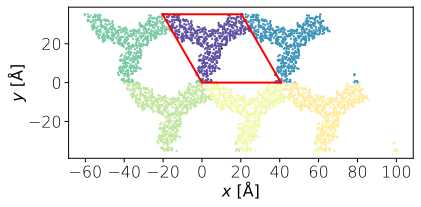

In [11]:
with plt.style.context('./include/notebook.mplstyle'):
    fig,ax = plt.subplots()
    ax.scatter(mcm41_xyz['x'],mcm41_xyz['y'],s=2)
    ax.plot([0,cell_length_a],[0,0],color='r')
    ax.plot([0,cell_length_b*np.cos(cell_angle_gamma)],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
    ax.plot([cell_length_b*np.cos(cell_angle_gamma),cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[cell_length_b*np.sin(cell_angle_gamma),cell_length_b*np.sin(cell_angle_gamma)],color='r')
    ax.plot([cell_length_a,cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
    ax.scatter(mcm41_xyz['x']+ax1,mcm41_xyz['y'],s=2)
    ax.scatter(mcm41_xyz['x']-ax1,mcm41_xyz['y'],s=2)
    ax.scatter(mcm41_xyz['x']-ax1-ax2,mcm41_xyz['y']-ay2,s=2)
    ax.scatter(mcm41_xyz['x']-ax2,mcm41_xyz['y']-ay2,s=2)
    ax.scatter(mcm41_xyz['x']+ax1-ax2,mcm41_xyz['y']-ay2,s=2)
    ax.scatter([(ax2+ax1)/2],[(ay2+ay1)/2],color='k',s=2)
    ax.set_aspect(1)
    ax.set_xlabel(r"$x\ \mathrm{[\AA]}$")
    ax.set_ylabel(r"$y\ \mathrm{[\AA]}$")

<a id='centering_the_unit_cell'></a>
### Centering the unit cell
[Table of Contents](#table_of_contents)

We can easily see the cif file was not centered on pore. Let's shift the xyz file data in order to have a pore centered unit cell. First we determine the pore center within the unit cell by finding the point that maximizes the sum of the distance between it and all atoms in the unit cell using periodic boundary conditions in the xy-plane.

In [12]:
def putInBC(r,side,pSide = None):
    """Puts r in periodic boundary conditions"""
    pSide = side if not pSide else pSide
    ind = (r >= (0.5 * side)) + r < -(0.5 * side)
    s = r
    s[ind] = (r[ind] + 2*side[ind]) % side[ind]
    s[s>=.5*side] -= side[s>=.5*side]
    return s

In [13]:
def total_distance_inv(r,r_cell,side,pSide = None):
    """Minimizing this function will maximize distance from each atom in the unit cell"""
    sep = []
    for s in (r_cell - r):
        sep.append(putInBC(s,side,pSide).tolist())
    return -np.sum(np.linalg.norm(np.array(sep),axis=1))

Before we continue, we need transfer matrices in order to go between the unit cell reference frame and the cartesian reference frame.

In [14]:
# Set up transfer matrices to transfer from unit cell coordinates to Cartesian coordinates
B = np.array([[1,np.cos(cell_angle_gamma)],[0,np.sin(cell_angle_gamma)]]) #transfer to Cartesian
A = np.linalg.inv(B) #transfer to unit cell coords

side = np.array([cell_length_a,cell_length_b]) #side lengths of unit cell
xy = np.array([mcm41_xyz['x'],mcm41_xyz['y']]).T #xy coordinates of all atoms in MCM-41
xy_uc = np.dot(A,xy.T).T-(side/2.0) #xy in unit cell coordinates

Here we plot the birdseye view of the original atom positions and then the convereted positions to show the transfer matrices are working correctly. 

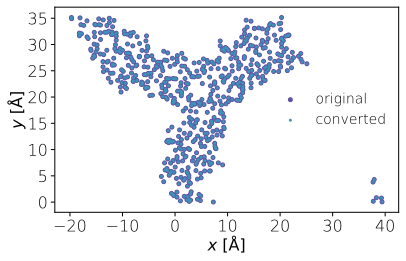

In [15]:
with plt.style.context('./include/notebook.mplstyle'):
    fig,ax = plt.subplots()
    ax.scatter(xy[:,0],xy[:,1],label="original",s=16)
    _xy_from_uc = np.dot(B,np.dot(A,xy.T)).T
    ax.scatter(_xy_from_uc[:,0],_xy_from_uc[:,1],label="converted",s=4)
    ax.legend(frameon=False,loc="center right")
    ax.set_aspect(1)
    ax.set_xlabel(r"$x\ \mathrm{[\AA]}$")
    ax.set_ylabel(r"$y\ \mathrm{[\AA]}$")

The points sit right on top of eachother! Now we can begin searching for the center of the pore.

In [16]:
initial_guess_uc = np.array([0.75*side[0],0.25*side[1]]) #pore center is in that empty space somewhere!
initial_guess = np.dot(B,initial_guess_uc) # initial guess in unit Cartesian coordinates

In [17]:
pore_center_uc = minimize(total_distance_inv,initial_guess_uc,args=(xy_uc,side)) # Pore center unit cell coordinates

In [18]:
print(pore_center_uc.x)

[48.15170534 30.09335426]


Now that we have the pore center in terms of unit cell coordinates, we transfer to Cartesian coordinates.

In [19]:
pore_center = np.dot(B,putInBC(pore_center_uc.x,side)+side/2) # Pore center in Cartesian coordinates (shift back before inversion)

Now let's plot to see if the value determined makes sense.

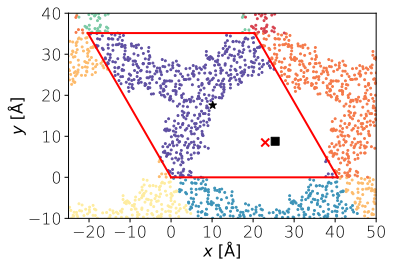

In [20]:
with plt.style.context('./include/notebook.mplstyle'):
    fig,ax = plt.subplots()
    ax.scatter(mcm41_xyz['x'],mcm41_xyz['y'],s=4)
    ax.plot([0,cell_length_a],[0,0],color='r')
    ax.plot([0,cell_length_b*np.cos(cell_angle_gamma)],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
    ax.plot([cell_length_b*np.cos(cell_angle_gamma),cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[cell_length_b*np.sin(cell_angle_gamma),cell_length_b*np.sin(cell_angle_gamma)],color='r')
    ax.plot([cell_length_a,cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
    for i in range(-3,3):
        for j in range(-3,3):
            if (i!=0) or (j!=0):
                ax.scatter(mcm41_xyz['x']+i*ax1+j*ax2,mcm41_xyz['y']+i*ay1+j*ay2,s=4)
    #ax.scatter([(ax2+ax1)/2],[(ay2+ay1)/2],color='k')
    ax.scatter(initial_guess[0],initial_guess[1],color='k',label=r'unit cell center',marker="s")
    ax.scatter(pore_center[0],pore_center[1],color='r',label=r'pore center',marker="x")
    ax.scatter(np.dot(B,side/2.0)[0],np.dot(B,side/2.0)[1],color='k',label=r'unit cell center',marker="*")
    ax.set_xlim(-25,50)
    ax.set_ylim(-10,40)
    ax.set_aspect(1)
    ax.set_xlabel(r"$x\ \mathrm{[\AA]}$")
    ax.set_ylabel(r"$y\ \mathrm{[\AA]}$")

The x marks the center of the pore, the star marks the center of the unit cell, and the square marks the initial guess. The x seems reasonable so now we shift the unit cell to be centered on pore.

In [21]:
xy_uc_shifted = []
for c in xy_uc-pore_center_uc.x:
    xy_uc_shifted.append(putInBC(c,side))
xy_uc_shifted = np.array(xy_uc_shifted)

In [22]:
xy_shifted = []
for c in xy_uc_shifted:
    xy_shifted.append(np.dot(B,c + side/2.0))
xy_shifted = np.array(xy_shifted)

In [23]:
unit_cell_center = np.dot(B,side/2.0)

Now we plot the new unit cell.

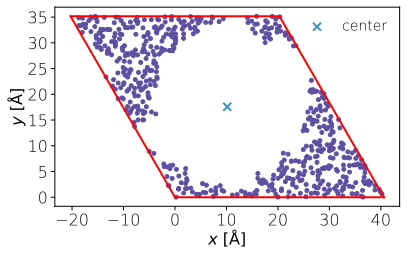

In [24]:
with plt.style.context('./include/notebook.mplstyle'):
    fig,ax = plt.subplots()
    ax.scatter(xy_shifted[:,0],xy_shifted[:,1],s=16)
    ax.plot([0,cell_length_a],[0,0],color='r')
    ax.plot([0,cell_length_b*np.cos(cell_angle_gamma)],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
    ax.plot([cell_length_b*np.cos(cell_angle_gamma),cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[cell_length_b*np.sin(cell_angle_gamma),cell_length_b*np.sin(cell_angle_gamma)],color='r')
    ax.plot([cell_length_a,cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
    ax.scatter(unit_cell_center[0],unit_cell_center[1],label=r'center',marker="x")
    ax.set_xlabel(r'$x$ $\mathrm{[\AA]}$')
    ax.set_ylabel(r'$y$ $\mathrm{[\AA]}$')
    ax.set_aspect(1)
    ax.legend(loc="upper right",frameon=False)
    #fig.savefig('plots/MCM-41-shifted.svg',bbox_inches='tight')

Now we shift so the unit cell is centered at (0,0,0).

In [25]:
mcm41_xyz_shifted = np.copy(mcm41_xyz)

In [26]:
mcm41_xyz_shifted['x'] = xy_shifted[:,0] - unit_cell_center[0]
mcm41_xyz_shifted['y'] = xy_shifted[:,1] - unit_cell_center[1]
mcm41_xyz_shifted['z'] -= cell_length_c/2.0

<a id='the_manybody_potential'></a>
### The manybody potential
[Table of Contents](#table_of_contents)

Now that we have the unit cell centered on pore, we are almost ready to generate the effective helium-MCM-41 manybody potential. We will use a superposition of the standard 12-6 Lennard-Jones potential for each atom in the unit cell over a semi-infinite supercell
\begin{equation}
    U_\mathrm{MCM-41}^\mathrm{He}(\vec{r}) = \sum_{i,j,k = -\infty}^\infty \sum_\alpha^N 4\varepsilon_\alpha \biggl( \frac{\sigma_\alpha^{12}}{\lvert \vec{r} - \vec{r}_{ijk\alpha}\rvert^{12}} - \frac{\sigma_\alpha^6}{\lvert \vec{r} - \vec{r}_{ijk\alpha}\rvert^6} \biggr)
\end{equation}
where $\alpha$ indexes over each atom within the unit cell, $\varepsilon_\alpha$ and $\sigma_\alpha$ are the appropriately mixed Lennard-Jones parameters, and
\begin{equation}
\vec{r}_{ijk\alpha} = \vec{r}_\alpha + i\vec{A}_a + j\vec{A}_b + k\vec{A}_c
\end{equation}
is the position of each atom within the semi-infinite supercell with unit cell vectors $\vec{A}_{\{a,b,c\}}$.

First, we determine appropriate Lennard-Jones parameters for each species.

In [27]:
# The Lennard-Jones parameters here correspond to those of the CVFF force field.
# See https://doi.org/10.1021/jp203831q
sigmaarr = np.array([(4.55,3.21,2.75,2.640,3.405,2.782)],dtype=[('Si','f'),('O','f'),('H','f'),('He','f'),('Ar','f'),('Ne','f')])
epsilonarr = np.array([(20.2,115.2,13.5,10.9,119.8,37.29134539)],dtype=[('Si','f'),('O','f'),('H','f'),('He','f'),('Ar','f'),('Ne','f')])

\begin{array}{c|cc}
    \mathrm{atom} & \sigma & \epsilon \\
    \hline
    \mathrm{Si_{MCM\unicode{x2013} 41}} & 4.55   & 20.2 \\
    \mathrm{O_{MCM\unicode{x2013} 41}}  & 3.21   & 115.2 \\
    \mathrm{H_{MCM\unicode{x2013} 41}}  & 2.75   & 13.5 \\
    \mathrm{He}          & 2.640  & 10.9 \\
\end{array}

Now we mix the $\sigma$ and $\epsilon$ parameters for each atom within the unit cell and the parameters for the helium atom using the standard Lorentz-Berthelot mixing rules.

\begin{equation}
    \sigma_\alpha = \frac{\sigma_\alpha^\mathrm{MCM-41} + \sigma^\mathrm{He}}{2}
\end{equation}

\begin{equation}
    \varepsilon_\alpha = \sqrt{\sigma_\alpha^\mathrm{MCM-41}\sigma^\mathrm{He}}
\end{equation}

Let's begin by shifting the xyz positions of the MCM-41 and setting up the mixed $\sigma$ and $\epsilon$ parameters.

In [29]:
# functions to mix the LJ parameters
# See https://doi.org/10.1016/S0927-7757(01)00628-8
def mixsigma(s1,s2):
    return (s1+s2)/2.0

def mixepsilon(e1,e2):
    return (e1*e2)**0.5

# Some convenience arrays for sigma and epsilon while iterating through atom positions
sarr = np.zeros_like(mcm41_xyz_shifted['x'])
earr = np.zeros_like(mcm41_xyz_shifted['x'])
for n in sigmaarr.dtype.names:
    n_byte = str.encode(n)
    sarr[mcm41_xyz_shifted['type_symbol']==n_byte] = mixsigma(sigmaarr[n],sigmaarr['He'])
    earr[mcm41_xyz_shifted['type_symbol']==n_byte] = mixepsilon(epsilonarr[n],epsilonarr['He'])

\begin{array}{c|cc}
    \mathrm{atom\ pair} & \sigma_\alpha & \epsilon_\alpha \\
    \hline
    \mathrm{He}-\mathrm{Si_{MCM\unicode{x2013} 41}} & 3.60 & 14.84 \\
    \mathrm{He}-\mathrm{O_{MCM\unicode{x2013} 41}}  & 2.93 & 35.44 \\
    \mathrm{He}-\mathrm{H_{MCM\unicode{x2013} 41}}  & 2.70 & 12.13 \\
    \mathrm{He}-\mathrm{Ar}                         & 3.02 & 36.14 \\
\end{array}

Now we have all the pieces to generate the manybody potential. Here we save the data we need and open in a new notebook coded in Julia to perform the manybody potential calculation.

In [73]:
np.savez("data/mcm41_xyz_shifted_CVFF", x = mcm41_xyz_shifted["x"], y = mcm41_xyz_shifted["y"], z = mcm41_xyz_shifted["z"], sigma = sarr, epsilon = earr)

In [74]:
np.savez("data/mcm41_lattice_vectors",A1 = np.array([ax1,ay1,0.0,]),A2 = np.array([ax2,ay2,0.0]), A3 = np.array([0.0,0.0,az]))

<a id='calculating_the_manybody_potential'></a>
### Calculating the manybody potential
[Table of Contents](#table_of_contents)

The calculation of the manybody potential is performed using [Julia](https://julialang.org/) in the [calculating the effective manybody potential notebook](./calculating_the_effective_manybody_potential_JULIA.ipynb#table_of_contents).

<a id='determining_the_effective_parameters_to_cylindrical_potential'></a>
### Determining the effective parameters to cylindrical potential
[Table of Contents](#table_of_contents)

In [31]:
from scipy.special import ellipk, ellipe
from scipy.interpolate import griddata
from matplotlib.patches import Circle
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import include.colors as colortools
from scipy.integrate import simps
import matplotlib.pyplot as plt
from os import path
import numpy as np
import pickle

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

def save_as_pickle(fn,data):
    with open(fn, 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [32]:
plot_colors = colortools.get_linear_colors('viridis',10)

In [33]:
dark_purple = plot_colors[0]
purple = plot_colors[1]
dark_blue = plot_colors[2]
blue = plot_colors[3]
teal = plot_colors[4]
aquamarine = plot_colors[5]
green = plot_colors[6]
light_green = plot_colors[7]
dead_grass = plot_colors[8]
yellow = plot_colors[9]

The [generated 3d manybody potential](./calculating_the_effective_manybody_potential_JULIA.ipynb#table_of_contents) can be mapped to an integrated Lennard-Jones potential for a cylindrical pore in an infinite continuous media,
\begin{equation}
    U_{\rm cyl} (r;R) = \frac{\pi n \varepsilon\sigma^3}{3}\biggl[\bigl(\frac{\sigma}{R}\bigr)^9 \mathop{u_9}(\frac{r}{R}) - \bigl(\frac{\sigma}{R}\bigr)^3 \mathop{u_3}(\frac{r}{R})\biggr]
    \label{eq:Vpore}
\end{equation}
with
\begin{equation*}
    u_9(x) = \frac{1}{240(1-x^2)^9} \bigl[(1091 + 11156x^2 + 16434x^4 + 4052x^6 + 35x^8)E(x)- 8(1-x^2)(1+7x^2)(97+134x^2+25x^4)K(x)\bigr]
\end{equation*}
and
\begin{equation*}
    u_3(x) = \frac{2}{(1-x^2)^3} [(7+x^2)E(x) - 4(1-x^2)K(x)]
\end{equation*}
where $n$ is the density of the media, $\varepsilon$ is the strength of the interaction, $\sigma$ is the hard core distance, $R$ is the pore radius, and $K(x)$ and $E(x)$ are the complete elliptic integrals of the first and second kind.

The parameters $\sigma$, $n\varepsilon$, and $R$ are determined via a non-linear least squares fitting routine for the data at each $z$-slice to $U_\mathrm{cyl}$. The extreme values for the potential within the pore walls will cause numerical instablites to the fit so two methods are explored. The first method uses a potential cutoff for the data at each slice, while the second method uses a radial cutoff. We begin by defining $U_\mathrm{cyl}$ and loading the 3D manybody potential.

In [34]:
def U_cyl(r,σ,nε,R):
    pf = np.pi*nε*(σ**3)/3.0
    t9 = u9(r/R)*((σ/R)**9)
    t3 = u3(r/R)*((σ/R)**3)
    return pf*(t9-t3)

def u9(x):
    pf = 1.0/(240.0*((1.0-(x**2))**9))
    t1 = (1091.0 + (11156.0*(x**2)) + (16434.0*(x**4)) + (4052.0*(x**6)) + (35*(x**8)))*ellipe(x**2)
    t2 = 8.0 * (1.0-(x**2)) * (1.0 + (7.0*(x**2))) * (97.0 + (134.0*(x**2)) + (25.0*(x**4))) * ellipk(x**2)
    return pf*(t1-t2)

def u3(x):
    pf = 2.0/((1.0-(x**2))**3)
    t1 = (7.0 + (x**2)) * ellipe(x**2)
    t2 = 4.0 * (1.0-(x**2)) * ellipk(x**2)
    return pf*(t1-t2)

In [35]:
V_data = np.load("data/V_3D_-20.0_20.0_-20.0_20.0_-6.10_6.10_101_CVFF.npz")

These convience functions to convert between Cartesian and polar coordinates will be useful too since one of the methods has a radial cutoff.

In [36]:
def cart2pol(x, y):
    """convert from cartesian to polar coordinates"""
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    """convert from polar to cartesian coordinates"""
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

<a id='effective_parameters_using_potential_cutoff'></a>
#### Effective parameters using potential cutoff
[Table of Contents](#table_of_contents)

Now we initialize the data for the fitting procedure and perform the fit.

In [37]:
V = V_data["V"]
z_range = V_data["z_range"]
r,phi = cart2pol(V_data["x_grid"],V_data["y_grid"])

σ = np.zeros_like(z_range)
nε = np.zeros_like(z_range)
R = np.zeros_like(z_range)
σ_error = np.zeros_like(z_range)
nε_error = np.zeros_like(z_range)
R_error = np.zeros_like(z_range)
r_cutoff = np.zeros_like(z_range)

In [ ]:
for i,z in enumerate(z_range):
    print("z = {0:.2f}:\t{1:.2f}% progress".format(z,100*(i+1)/z_range.shape[0]), end="\r")
    U = V[:,:,i] # potential at each z-slice
    xdata = r.flatten()
    ydata = U.flatten()
    x_sort_idx = np.argsort(xdata)
    ydata = ydata[x_sort_idx]
    xdata = xdata[x_sort_idx]
    
    # The extreme values are mitigated via a potential cutoff
    max_U = 0.0

    # Here we get the index for all values less than the cutoff
    fitind = (ydata <= max_U)

    # This holds the largest r value in the slice after masking
    r_cutoff[i] = np.max(xdata[fitind])

    # Perform the non-linear least squares fit
    popt, pcov = curve_fit(U_cyl, xdata[fitind], ydata[fitind],[2.5,5,r_cutoff[i]+5],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)
    perr = np.sqrt(np.diag(pcov)) # error in fit parameters

    # Store fit parameters and error
    σ[i],nε[i],R[i] = popt
    σ_error[i],nε_error[i],R_error[i] = perr

In [ ]:
with plt.style.context('./include/notebook.mplstyle'):
    _r = np.linspace(0,30,1001)
    fig,ax = plt.subplots()
    for i in range(len(σ)):
        _σ = σ[i]
        _nε = nε[i]
        _R = R[i]
        ax.plot(_r,U_cyl(_r,_σ,_nε,_R),label=r"$U_\mathrm{cyl}$")
    ax.set_ylim(-550,0)
    ax.set_xlabel(r"$r\ [\mathrm{\AA}]$")
    ax.set_ylabel(r"$U_\mathrm{cyl}\ [\mathrm{K}]$")

<a id='effective_parameters_using_radial_cutoff'></a>
#### Effective parameters using radial cutoff
[Table of Contents](#table_of_contents)

Again, we initialize the data for the fitting procedure and perform the fit. Here we determine the radial cutoff for each slice as the closest point where the potential is greater than 0K.

In [ ]:
V = V_data["V"]
z_range = V_data["z_range"]
r_close,phi_close = cart2pol(V_data["x_grid"],V_data["y_grid"])

σ_close = np.zeros_like(z_range)
nε_close = np.zeros_like(z_range)
R_close = np.zeros_like(z_range)
σ_error_close = np.zeros_like(z_range)
nε_error_close = np.zeros_like(z_range)
R_error_close = np.zeros_like(z_range)
r_cutoff_close = np.zeros_like(z_range)

In [ ]:
# We need to ensure each slice is sorted properly to find the radial cutoff
xdata = r_close.flatten()
x_sort_idx = np.argsort(xdata)
xdata = xdata[x_sort_idx]

In [ ]:
for i,z in enumerate(z_range):
    print("z = {0:.2f}:\t{1:.2f}% progress".format(z,100*(i+1)/z_range.shape[0]), end="\r")
    U_close = V[:,:,i]
    ydata = U_close.flatten()[x_sort_idx]
    
    # Here we determine the radial cutoff for each slice as the closest point where the potential is greater than 0 K
    max_U = 0.0

    # Index for all points greater than max potential cutoff
    fitindU = (ydata >= max_U)
    skip_begining_zeros_idx = xdata > 5.0 # we need this incase some of the values at begining are zero

    # The first element of this array will be the closest point
    # where the potential crosses zero (since the data was sorted by radius)
    r_cut_fit_close = xdata[fitindU * skip_begining_zeros_idx][0]

    # Now we can filter the data using the radial cutoff!
    fitind = (xdata <= r_cut_fit_close)

    # Store the radial cutoff value
    r_cutoff_close[i] = np.max(xdata[fitind])

    # Perform the fit
    popt_close, pcov_close = curve_fit(U_cyl, xdata[fitind], ydata[fitind],[2.5,5,r_cutoff_close[i]+5],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)
    perr_close = np.sqrt(np.diag(pcov_close)) # Store error in parameters

    # Store parameters and error
    σ_close[i],nε_close[i],R_close[i] = popt_close
    σ_error_close[i],nε_error_close[i],R_error_close[i] = perr_close

In [ ]:
with plt.style.context('./include/notebook.mplstyle'):
    _r = np.linspace(0,30,1001)
    fig,ax = plt.subplots()
    for i in range(len(σ_close)):
        _σ_close = σ_close[i]
        _nε_close = nε_close[i]
        _R_close = R_close[i]
        ax.plot(_r,U_cyl(_r,_σ_close,_nε_close,_R_close),label=r"$U_\mathrm{cyl}$")
    ax.set_ylim(-130,0)
    ax.set_xlim(0,15)
    ax.set_xlabel(r"$r\ [\mathrm{\AA}]$")
    ax.set_ylabel(r"$U_\mathrm{cyl}\ [\mathrm{K}]$")

In [ ]:
with plt.style.context('./include/notebook.mplstyle'):
    _r = np.linspace(0.000001,30,1001)
    fig,ax = plt.subplots()
    for i in range(len(σ)):
        _σ = σ[i]
        _nε = nε[i]
        _R = R[i]
        ax.plot(_r,U_cyl(_r,_σ,_nε,_R),label=r"$U_\mathrm{cyl}^4$")

    for i in range(len(σ_close)):
        _σ_close = σ_close[i]
        _nε_close = nε_close[i]
        _R_close = R_close[i]
        ax.plot(_r,U_cyl(_r,_σ_close,_nε_close,_R_close),label=r"$U_\mathrm{cyl}^4$")

    ax.plot(_r,U_cyl(_r,3.44,1.59,15.51),label="USED",linestyle="--")

    ax.set_ylim(-550,0)
    ax.set_xlabel(r"$r\ [\mathrm{\AA}]$")
    ax.set_ylabel(r"$U_\mathrm{cyl}\ [\mathrm{K}]$")

When comparing the two methods we see a great disparity between the recovered potentials, $U_\mathrm{cyl}$. The large potential well depths within the rough areas of the pore are being captured by the potential cutoff method. We expect those areas to be filled by the preplating material (argon in our case). This will cause futher attraction and deepening of the potentials determined via the radial cutoff method. We attempt to capture some of that character as well as match the experimental pore diameter in the parameters we chose to use (potential show as dashed line).

In [ ]:
cmap = plt.cm.get_cmap("viridis");
with plt.style.context('./include/aps.mplstyle'):
    _r = np.linspace(0.000001,30,1001)
    fig,ax = plt.subplots()
    sort_index = np.argsort(nε)[::-1]
    for ii,i in enumerate(sort_index):
        _σ = σ[i]
        _nε = nε[i]
        _R = R[i]
        ax.plot(_r,U_cyl(_r,_σ,_nε,_R),label=r"$U_\mathrm{cyl}^4$",color=cmap(ii/σ.shape[0]))

    sort_index = np.argsort(nε_close)[::-1]
    for ii,i in enumerate(sort_index):
        _σ_close = σ_close[i]
        _nε_close = nε_close[i]
        _R_close = R_close[i]
        ax.plot(_r,U_cyl(_r,_σ_close,_nε_close,_R_close),label=r"$U_\mathrm{cyl}^4$",color=cmap(ii/σ_close.shape[0]))

    ax.plot(_r,U_cyl(_r,3.44,1.59,15.51),label="USED",linestyle="--",color=teal)

    ax.set_ylim(-550,0)
    ax.set_xlabel(r"$r\ [\mathrm{\AA}]$")
    ax.set_ylabel(r"$U_\mathrm{cyl}\ [\mathrm{K}]$")
    fig.savefig("plots/cylindrical_potential_effective_parameters.pdf",dpi=400)

In [ ]:
interpolate_res = 10001j
extent = V_data["extent"]
grid_x, grid_y = np.mgrid[extent[0]:extent[1]:interpolate_res, extent[2]:extent[3]:interpolate_res]
linear_interpolation_z0 = griddata((V_data["x_grid"].flatten(),V_data["y_grid"].flatten()), V[:,:,51].flatten(), (grid_x, grid_y), method='linear')


Below shows the data fit to using both methods for the $z=0.0\unicode{x212B}$ slice. The potential cutoff method uses all the data displayed within the heatmap, while the radial cutoff only uses the data within the red circle. An minimum cutoff value for the potential of $-200\mathrm{K}$ has been used here for display purposes.

In [ ]:
with plt.style.context('./include/notebook.mplstyle'):
    fig,ax = plt.subplots()
    _Vtmp = np.copy(linear_interpolation_z0)
    _Vtmp[
        (_Vtmp > 0.0) +
        ((grid_x > 10.0)*(grid_y > 15.0)) +
        ((grid_x < -10.0)*(grid_y > 10.0)) +
        ((grid_x < -10.0)*(grid_y < -15.0)) +
        ((grid_x > 10.0)*(grid_y < -15.0))
    ] = np.nan
    im = ax.imshow(_Vtmp.T,origin="lower",extent=extent,vmin=-200,vmax=0,interpolation="none")
    fig.colorbar(im)
    circ = Circle((0,0),r_cutoff_close[51],facecolor='None',edgecolor='C8',linestyle = "-",linewidth=3)
    ax.add_patch(circ)
    ax.set_xlabel(r"$r\ [\mathrm{\AA}]$")
    ax.set_ylabel(r"$U_\mathrm{cyl}\ [\mathrm{K}]$")
    #fig.savefig("plots/cylindrical_potential_effective_parameters_z0.pdf",dpi=400)


In [ ]:
with plt.style.context('./include/aps.mplstyle'):
    fig,ax = plt.subplots()
    _Vtmp = np.copy(linear_interpolation_z0)
    _Vtmp[
        (_Vtmp > 0.0) +
        ((grid_x > 10.0)*(grid_y > 15.0)) +
        ((grid_x < -10.0)*(grid_y > 10.0)) +
        ((grid_x < -10.0)*(grid_y < -15.0)) +
        ((grid_x > 10.0)*(grid_y < -15.0))
    ] = np.nan
    #im = ax.imshow(V[:,:,51].T,origin="lower",extent=extent,vmin=-200,vmax=0,interpolation='none')
    im = ax.imshow(_Vtmp.T,origin="lower",extent=extent,vmin=-200,vmax=0,interpolation='none')
    fig.colorbar(im)
    circ = Circle((0,0),r_cutoff_close[51],facecolor='None',edgecolor='tab:red',linestyle = "-",linewidth=2)
    ax.add_patch(circ)
    ax.set_xlabel(r"$r\ [\mathrm{\AA}]$")
    ax.set_ylabel(r"$U_\mathrm{cyl}\ [\mathrm{K}]$")
    ax.annotate(r"$z=0\ \mathrm{\AA}$",(0.04,0.90),xycoords="axes fraction")
    fig.savefig("plots/cylindrical_potential_effective_parameters_z0.pdf",dpi=400)